In [61]:
import pandas as pd
import numpy as np
import os
import scipy
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import umap

In [62]:
# 10 dims
models_dirs = {'beta_vae_1': '/neurospin/dico/jlaval/Runs/02_STS_babies/Program/Output/BetaVAE/2023-12-11/14-10-52/analysis/embeddings_dHCP.csv',
               'beta_vae_2': '/neurospin/dico/jlaval/Runs/02_STS_babies/Program/Output/BetaVAE/2023-12-18/13-54-42/analysis/embeddings_dHCP.csv',
               'beta_vae_3': '/neurospin/dico/jlaval/Runs/02_STS_babies/Program/Output/BetaVAE/2023-12-18/16-56-49/analysis/embeddings_dHCP.csv',
               'simclr_1': '/neurospin/dico/jlaval/Runs/02_STS_babies/Program/Output/2023-11-29/15-49-36_0/dHCP_embeddings/full_embeddings.csv',
               'simclr_2': '/neurospin/dico/jlaval/Runs/02_STS_babies/Program/Output/2023-11-29/15-49-36_1/dHCP_embeddings/full_embeddings.csv',
               'simclr_3': '/neurospin/dico/jlaval/Runs/02_STS_babies/Program/Output/2023-11-29/15-49-36_2/dHCP_embeddings/full_embeddings.csv',
               'simclr_4': '/neurospin/dico/jlaval/Runs/02_STS_babies/Program/Output/2023-11-29/09-59-38_188/dHCP_embeddings/full_embeddings.csv',
               'simclr_5': '/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/2023-06-15/14-36-49/STs_dHCP_374_subjects_embeddings/full_embeddings.csv'}

#df_dHCP = pd.read_csv(model_dir+'/dHCP_embeddings.csv')

In [63]:
# load embeddings
for model, directory in models_dirs.items():
    embeddings = pd.read_csv(directory)
    models_dirs[model]=embeddings

In [64]:
# peut-être vaudrait-il mieux travailler avec la mutual information. Et utiliser les représentations d'UKB ? Mais comment traduire la distribution en probabilité ? Et comment traduire une "loi jointe ?"

In [65]:
scaler = StandardScaler() # ne change pas le score de régression

In [66]:
models_embeddings = models_dirs.copy()
dims = [f'dim{k}' for k in range(1, 11)]
for name, model in models_embeddings.items():
    model = model[dims].to_numpy()
    model = scaler.fit_transform(model)
    models_embeddings[name] = model


# use linear regression

In [67]:
correl_matrix = np.zeros((len(models_dirs), len(models_dirs)))
for i, (name1, model1) in enumerate(models_embeddings.items()):
    for j, (name2, model2) in enumerate(models_embeddings.items()):
        reg = LinearRegression().fit(model1, model2)
        sc = reg.score(model1, model2)
        #print(f'{name1} {name2}: {sc}')
        correl_matrix[i,j]=sc

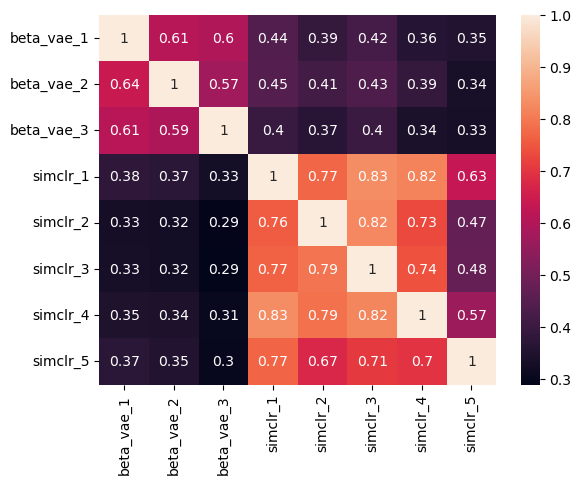

In [68]:
ticklabels = models_dirs.keys()
sns.heatmap(correl_matrix, annot=True, xticklabels=ticklabels, yticklabels=ticklabels)
plt.show()

# Use disimilarity matrix (pairwise euclidean distance)
Beware: the metric is asymmetric, maybe average ?
Use euclidean or cosine distance ? euclidean for betavae and cosine for simclr ?

In [220]:
# compute pairwise euclidean distance between all subjects and select a restricted neighborhood
proportion = 0.2
nb_subjects = models_embeddings['simclr_1'].shape[0]
nb_neigh = int(nb_subjects * proportion)
nb_models = len(models_embeddings.keys())
tau_mat, p_value_mat = np.zeros((nb_models, nb_models)), np.zeros((nb_models, nb_models))

for i, (name1, model1) in enumerate(models_embeddings.items()):
    for j, (name2, model2) in enumerate(models_embeddings.items()):

        selected_dists_1 = []
        selected_dists_2 = []
        pairwise_dists_1 = euclidean_distances(model1)
        #pairwise_dists_1 = cosine_similarity(model1)
        pairwise_dists_2 = euclidean_distances(model2)
        #pairwise_dists_2 = cosine_similarity(model2)
        for idx, (dists_1, dists_2) in enumerate(zip(pairwise_dists_1, pairwise_dists_2)):
            dists_1 = np.delete(dists_1, idx) #remove distance to itself
            dists_2 = np.delete(dists_2, idx)
            idxs=np.argsort(dists_1) #get closest subjects for model1
            selected_dists_1=selected_dists_1+dists_1[idxs[:nb_neigh]].tolist()
            selected_dists_2=selected_dists_2+dists_2[idxs[:nb_neigh]].tolist() #apply same subject selection to model2
        tau, p = scipy.stats.kendalltau(selected_dists_1, selected_dists_2)
        tau_mat[i,j]=tau
        p_value_mat[i,j]=p

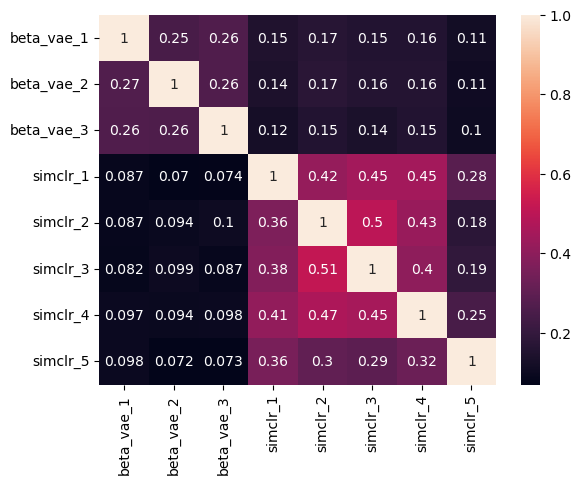

In [221]:
ticklabels = models_dirs.keys()
#fig, axs = plt.subplots(figsize=(12, 6), ncols=2)
sns.heatmap(tau_mat, annot=True, xticklabels=ticklabels, yticklabels=ticklabels)
#sns.heatmap(p_value_mat, annot=True, xticklabels=ticklabels, yticklabels=ticklabels, ax=axs[1])
plt.show()

# COMPARISON TO MORPHOMETRY

In [5]:
mods = {'B-VAE': [],
        'SimCLR': [],
        'morpho all': [],
        'morpho shape': [],
        'morpho pos': []}

sulci = ['S.T.s', 'CINGULATE']
sides = ['left', 'right']

models = {sulcus+'_'+side: mods for sulcus in sulci for side in sides}

In [52]:
# select morpho rows based on info dHCP and simple morpho to get measures corresponding to right sessions
# done only once to define the indexes to keep
info_dHCP = pd.read_csv('/neurospin/dico/jlaval/data/info_dHCP.csv')
sulcus = 'S.T.s._right'
morpho_params = ['hull_junction_length_talairach', 'maxdepth_talairach', 'GM_thickness', 'opening', 'meandepth_talairach', 'surface_talairach']
morpho_df = pd.DataFrame(columns=morpho_params)

for idx, (id, session, _, _) in info_dHCP.iterrows():
    morpho_dir = f'/neurospin/grip/external_databases/dHCP_CR_JD_2018/Projects/denis/release3_morpho_bids/sub-{id}/ses-{session}/anat/t1mri/default_acquisition/default_analysis/folds/3.1/default_session_auto/{id}_default_session_auto_sulcal_morphometry.csv'
    morpho = pd.read_csv(morpho_dir, sep=';')
    morpho_sulcus = morpho.loc[morpho['sulcus']==sulcus][morpho_params]
    morpho_df = morpho_df.append(morpho_sulcus)

df_morpho = pd.concat([info_dHCP, morpho_df.set_index(info_dHCP.index)], axis=1)

for idx, row in morpho.iterrows():
    if df_morpho.loc[df_morpho['participant_id']==row['subject']].shape[0]==0:
        morpho.drop(idx, inplace=True)
    elif row['hullJunctionsLength'] != df_morpho.loc[df_morpho['participant_id']==row['subject']].hull_junction_length_talairach.tolist()[0]:
        morpho.drop(idx, inplace=True)

index_to_keep = morpho.index.tolist()

KeyError: 'subject'

In [54]:
# compute and return 3 dfs
def format_morpho(df):

    length = df['hullJunctionsLength'].to_numpy()
    extremity1 = df[['extremity1x', 'extremity1y', 'extremity1z']].to_numpy()
    extremity2 = df[['extremity2x', 'extremity2y', 'extremity2z']].to_numpy()
    coords = extremity1-extremity2
    d = np.sqrt(np.square(coords[:,0]) + np.square(coords[:,1]) + np.square(coords[:,2]))

    foldness = (length - d) / length

    df['SulcusLength']=d # probably not used ?
    df['foldness']=foldness

    # first positional measures
    posi_params = ['gravityCenter_x', 'gravityCenter_y', 'gravityCenter_z',
                'normal_x', 'normal_y', 'normal_z',
                'direction_x', 'direction_y', 'direction_z']

    cols = [f'dim{k}' for k in range(1,len(posi_params)+1)]
    embeddings_pos = df[['subject']+posi_params]
    embeddings_pos.columns=['ID']+cols

    shape_params = ['surface', 'geodesicDepthMax', 'geodesicDepthMean', 'hullJunctionsLength',
                'connectedComponentsAllRels', 'connectedComponents', 'foldness']


    cols = [f'dim{k}' for k in range(1,len(shape_params)+1)]

    embeddings_shape = df[['subject']+shape_params]
    embeddings_shape.columns=['ID']+cols

    all_params = posi_params + shape_params

    cols = [f'dim{k}' for k in range(1,len(all_params)+1)]

    embeddings_all = df[['subject']+all_params]
    embeddings_all.to_csv('/neurospin/dico/data/deep_folding/current/datasets/dHCP_374_subjects/crops/2mm/S.T.s.baby/mask/morpho_labels.csv', index=False)
    embeddings_all.columns=['ID']+cols

    return(embeddings_all, embeddings_shape, embeddings_pos)

In [60]:
# load embeddings of each model
sulci = ['S.T.s'] # temporary...
sides = ['right']

#S.T.s_left
models['S.T.s_right']['B-VAE'] = pd.read_csv('/neurospin/dico/jlaval/Runs/02_STS_babies/Program/Output/BetaVAE/2023-12-11/14-10-52/analysis/embeddings_dHCP.csv')
models['S.T.s_right']['SimCLR'] = pd.read_csv('/neurospin/dico/jlaval/Runs/02_STS_babies/Program/Output/2023-11-29/09-59-38_188/dHCP_embeddings/full_embeddings.csv')

# morpho
for sulcus in sulci:
    for side in sides:
        morpho = pd.read_csv(f'/neurospin/dico/data/deep_folding/current/datasets/dHCP_374_subjects/morphometry/morphometry_statistics/right/morpho_{sulcus}._{side}.dat', sep=' ')
        morpho = morpho.loc[index_to_keep]
        morphos = format_morpho(morpho)
        models[f'{sulcus}_{side}']['morpho all'], models[f'{sulcus}_{side}']['morpho shape'], models[f'{sulcus}_{side}']['morpho pos'] = morphos[0], morphos[1], morphos[2]

In [122]:
def dist_embeddings(df1, df2, dist1='euclidean', dist2='euclidean', nb_neigh=-1):

    """
    Returns disymilarity between two embeddings using rank test on pairwise distances
    """

    # then select all subjects
    if nb_neigh == -1:
        nb_neigh = df1.shape[0]-1

    model1 = df1.drop('ID', axis=1).to_numpy()
    model2 = df2.drop('ID', axis=1).to_numpy()

    model1 = scaler.fit_transform(model1)
    model2 = scaler.fit_transform(model2)

    selected_dists_1 = []
    selected_dists_2 = []
    
    if dist1=='euclidean':
        pairwise_dists_1 = euclidean_distances(model1)
    elif dist1=='cosine':
        pairwise_dists_1 = cosine_similarity(model1)
    if dist2=='euclidean':
        pairwise_dists_2 = euclidean_distances(model2)
    elif dist2=='cosine':
        pairwise_dists_2 = cosine_similarity(model2)

    for dists_1, dists_2 in zip(pairwise_dists_1, pairwise_dists_2):
        dists_1 = np.delete(dists_1, 0) #remove distance to itself
        dists_2 = np.delete(dists_2, 0)
        idxs=np.argsort(dists_1) #get closest subjects for model1
        selected_dists_1=selected_dists_1+dists_1[idxs[:nb_neigh]].tolist()
        selected_dists_2=selected_dists_2+dists_2[idxs[:nb_neigh]].tolist() #apply same subject selection to model2
    print(selected_dists_1)
    tau, p = scipy.stats.kendalltau(selected_dists_1, selected_dists_2)
    
    return(tau, p)

In [123]:
dist_embeddings(models['S.T.s_right']['B-VAE'], models['S.T.s_right']['morpho all'], nb_neigh=1)

[1.8905247762793949, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

(1.0, 4.159184105772757e-83)

In [18]:
# y a-t-il des nans ? Récupérer les index pour supprimer les sujets avant de faire les calculs de distances pairwise...

In [215]:
df1 = models['S.T.s_right']['SimCLR']
df2 = models['S.T.s_right']['B-VAE']
dist1='euclidean'
dist2='euclidean'
nb_neigh=-1

# then select all subjects
if nb_neigh == -1:
    nb_neigh = df1.shape[0]-1

model1 = df1.drop('ID', axis=1).to_numpy()
model2 = df2.drop('ID', axis=1).to_numpy()

model1 = scaler.fit_transform(model1)
model2 = scaler.fit_transform(model2)

selected_dists_1 = []
selected_dists_2 = []

if dist1=='euclidean':
    pairwise_dists_1 = euclidean_distances(model1)
elif dist1=='cosine':
    pairwise_dists_1 = cosine_similarity(model1)
if dist2=='euclidean':
    pairwise_dists_2 = euclidean_distances(model2)
elif dist2=='cosine':
    pairwise_dists_2 = cosine_similarity(model2)

for idx, (dists_1, dists_2) in enumerate(zip(pairwise_dists_1, pairwise_dists_2)):
    dists_1 = np.delete(dists_1, idx) #remove distance to itself
    dists_2 = np.delete(dists_2, idx)
    idxs=np.argsort(dists_1) #get closest subjects for model1
    selected_dists_1=selected_dists_1+dists_1[idxs[:nb_neigh]].tolist()
    selected_dists_2=selected_dists_2+dists_2[idxs[:nb_neigh]].tolist() #apply same subject selection to model2
tau, p = scipy.stats.kendalltau(selected_dists_1, selected_dists_2)

In [216]:
tau, p

(0.21816386216584763, 0.0)